
# ENSTA prototype

General properties and simulations


---

## Equations of motion

For basics about float dynamics go [here](https://github.com/apatlpo/cognac/blob/master/instrum/float_dynamics_basics.ipynb)

We assume now that the float has the ability to control its volume between two bounds $V+v_{min}$ and $V+v_{max}$
with a precision $dv$.

---

## Control

We control the float vertical position with sliding modes, see [this notebook](https://github.com/apatlpo/cognac/blob/master/instrum/zcontrol_realistic.ipynb) for more details about control.


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import cognac.float as fl

WOA water profile at lon=6, lat=40


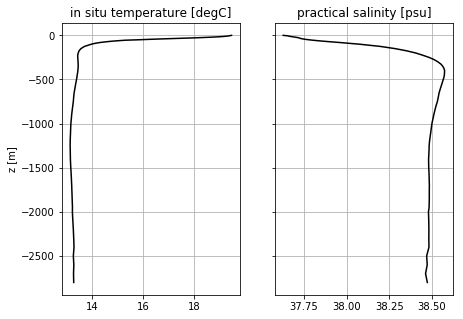

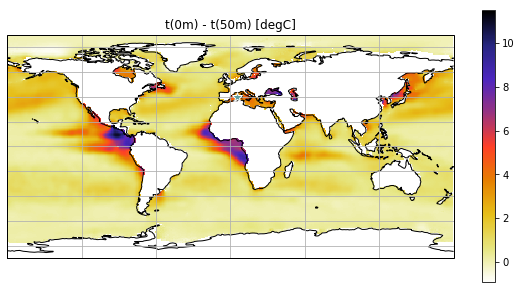

In [2]:
# select a water profile
#w = fl.waterp(lon=-50.,lat=40.) # Gulf Stream
w = fl.waterp(lon=6.,lat=40.) # Mediterranean sea
print(w)
w.show_on_map(zdiff=[0,50])

--- 
## Instantiate the float object

In [5]:
# Init now active control of the vertical position

#
z=np.arange(-350.,0.,1.)
rho_w, p, temp = w.get_rho(z), w.get_p(z), w.get_temp(z)

#
f = fl.autonomous_float(model='ENSTA')

# adjust mass to be at equilibrium at -25m
iz = np.argmin(np.abs(z+25))
f.adjust_m(p[iz],temp[iz],rho_w[iz])

# set vmax such that the float has an extra buoyancy at the surface equal
# to a cylinder ot 2cm radius and height of 10cm (antenna casing)
iz = np.argmin(np.abs(z+0.))
vmax = f.volume4equilibrium(p[iz],temp[iz],rho_w[iz]) + .1*np.pi*.02**2
# use d_max to prescribe piston max course
dmax = .07

#
f.init_piston(d_max=dmax,vol_max=vmax,vol=vmax)
print(f)

# compute bounds on motions
fmax, fmin, afmax, wmax = f.compute_bounds(w,-50.)

-3248.9 g  were added to the float in order to be at equilibrium at 25 dbar 

Piston max displacement set from max volume
Float parameters: 
  L     = 0.50 m      - float length
  r     = 0.06 m      - float radius
  m     = 5.80 kg     - float mass
  V     = 5.65e+03 cm^3   - float volume
  rho_cte = m/V = 1.02e+09 kg.cm^3   - float baseline density
  gamma = 9.30e-05 /dbar  - mechanical compressibility
  alpha = 0.00e+00 /degC  - thermal compressibility
  temp0 = 0.00e+00  degC  - reference temperature
  a = 1.00e+00  (no dimension)  - float added mass
  c0 = 0.00e+00  (no dimension)  - float drag parameter 0
  c1 = 1.00e+00  (no dimension)  - float drag parameter 1
Piston parameters and state: 
  r     = 25.00 mm        - piston radius
  phi   = 0.00 rad       - present angle of rotation
  d     = 0.00 mm        - present piston displacement
  vol   = 115.47 cm^3      - present volume addition
  lead  = 0.18 cm        - screw lead
  d_increment  = 0.00 m        - smallest variation 

In [6]:
# adjust piston to be at equilibrium 0m
iz = np.argmin(np.abs(z+0.))
vstart = f.set_piston4equilibrium(p[iz],temp[iz],rho_w[iz])
print('z equilibrium = %.1fm' %(f.z4equilibrium(w) ) ) # check

# compute float vertical displacement associated with 1mm piston displacement
#f.piston.update_d(f.piston.d+.001)
#f.piston_update_vol()
#print('z equilibrium after 1 mm piston displacement = %.1fm' %(f.z4equilibrium(w) ) )

Piston reset for equilibrium : vol=-1.0e+01 cm^3  
z equilibrium = -1.0m


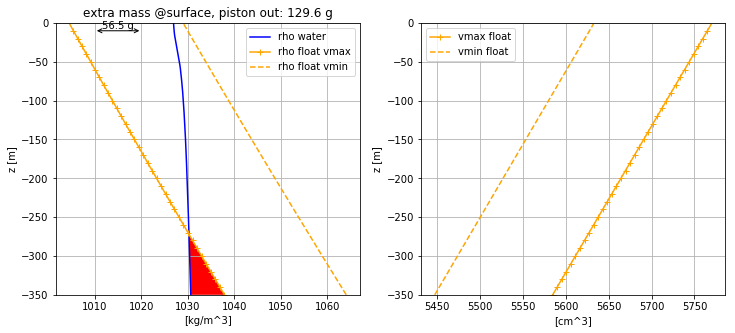

In [7]:
# show densities
fig, ax = plt.subplots(1, 2, figsize=(12,5))
fl.plot_float_density(z, f, w, ax=ax[0])
fl.plot_float_volume(z, f, w, ax=ax[1])

### equivalent volume and compressibilities

The float dynamics may be simplified and expressed as:
\begin{align}
2m\frac{d^2z_f}{dt^2}
+ m\frac{c_1}{2L} \Big |\frac{dz_f}{dt} \Big | \frac{dz_f}{dt} = 
g \rho (V_e + \gamma_e z + v),
\label{eq:zf_reg3}
\end{align}
where $V_e= V_0 [\delta\rho_w(\overline{z}) - \overline{z} \partial_z \rho_w ]/\rho$
and $\gamma_e = V_0 \partial_z \rho_w /\rho + \gamma_V$.


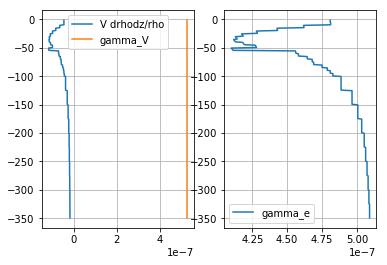

In [8]:
gamma_V = f.V*f.gamma
gamma_rho = f.V*np.diff(rho_w)/f.rho_cte/np.diff(z)
zm = (z[1:]+z[:-1])*.5

plt.figure()
ax=plt.subplot(121)
ax.plot(gamma_rho, zm, label='V drhodz/rho')
ax.plot(gamma_V+0.*zm, zm, label='gamma_V')
ax.grid()
ax.legend()

ax=plt.subplot(122)
ax.plot(gamma_rho+gamma_V, zm, label='gamma_e')
ax.grid()
ax.legend()

---

## From the surface down to a target level

In [9]:
# we start by constructing a trajectory that can be followed by the float
z_target = fl.descent(3600, -25., f, w, zstart = 0)

Acceleration and velocity bounds (zmin=-500m,zmax=0m):
fmax/m=2.2e-01 m^2/s, fmin/m= -4.4e-01 m^2/s, wmax= 384.8 cm/s
For accelerations, equivalent speed reached in 1min:
  fmax 1.3e+03 cm/s, fmin/m= -2.6e+03 cm/s


### feedback regulation, exact knowledge of the system

In [10]:
control = {'mode': 'feedback', 'tau': 1., 'dz_nochattering': 0.01, 'nu': 0.04*(2/np.pi), 'delta': 0.15}
f.time_step(w,T=1000., dt_step=.1, dt_log=1., z=0., w=0., v=vstart,
            piston=True, z_target=z_target, ctrl=control, kalman=None, verbose=0)

 ctrl: dt_ctrl = 0.1
 ctrl: dz_nochattering = 0.01
 ctrl: tau = 1.0
 ctrl: nu = 0.025464790894703257
 ctrl: delta = 0.15
 ctrl: gamma = 9.3e-05
 ctrl: L = 0.5
 ctrl: c1 = 1.0
 ctrl: m = 5.796134381066166
 ctrl: gammaV = 5.259026102109313e-07
 ctrl: rho = 1599.5071780735482
 ctrl: a = 1.0
 ctrl: mode = feedback
Start time stepping for 16 min ...
... time stepping done


Extrapolated energy conssumption: 6.6e-03 Wh/day = 0.2 Wh/30day


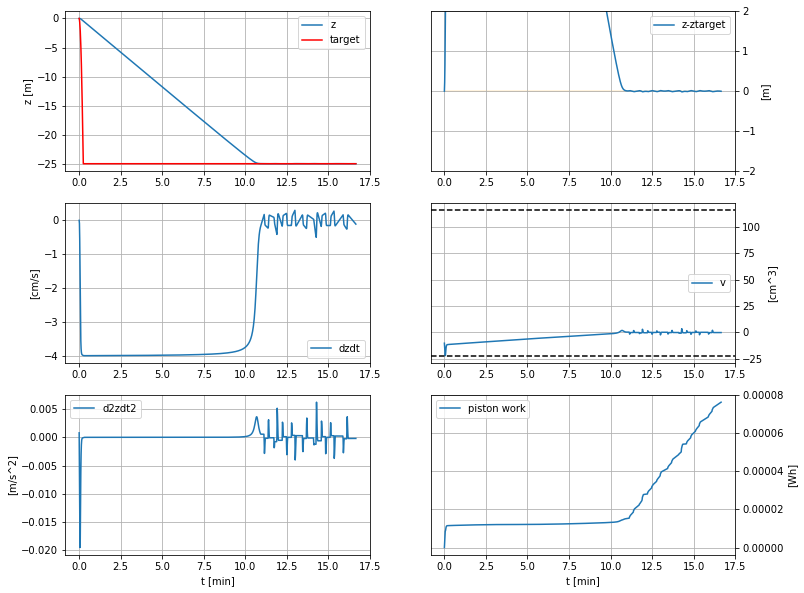

In [11]:
f.plot_logs(z_target=z_target)

### feedback with uncertain knowledge of the system: Kalman filter

In [12]:
#f = copy.deepcopy(f0)
#
#
dt = 1. #s
depth_rms = 1e-2 # m
vel_rms = depth_rms/dt # mm/s
Ve_rms = 1e-7
t2V = f.piston.vol_error  #vol_error = 7.e-08
gamma_alpha_gammaE = 1e-8
A_coeff = 9.81*f.rho_cte/((f.a+1)*f.m)
kalman = {'dt': dt, 'vol_error': t2V,
          'gammaV' : f.gammaV,
          'gamma': np.diag([vel_rms**2, depth_rms**2, gamma_alpha_gammaE**2, (10.*t2V)**2]),
          'gamma_alpha': (dt**2)*np.diag([(A_coeff*Ve_rms)**2, (depth_rms)**2, (gamma_alpha_gammaE)**2, (Ve_rms)**2] ),
          'gamma_beta': np.diag([depth_rms**2])}
#
f.time_step(w,T=1400., dt_step=.1, dt_log=1., z=0., w=0., v=vstart,
            piston=True, z_target=z_target, ctrl=control, kalman=kalman, verbose=0)

 ctrl: dt_ctrl = 0.1
 ctrl: dz_nochattering = 0.01
 ctrl: tau = 1.0
 ctrl: nu = 0.025464790894703257
 ctrl: delta = 0.15
 ctrl: gamma = 9.3e-05
 ctrl: L = 0.5
 ctrl: c1 = 1.0
 ctrl: m = 5.796134381066166
 ctrl: gammaV = 5.259026102109313e-07
 ctrl: rho = 1599.5071780735482
 ctrl: a = 1.0
 ctrl: mode = feedback
Start time stepping for 23 min ...
... time stepping done


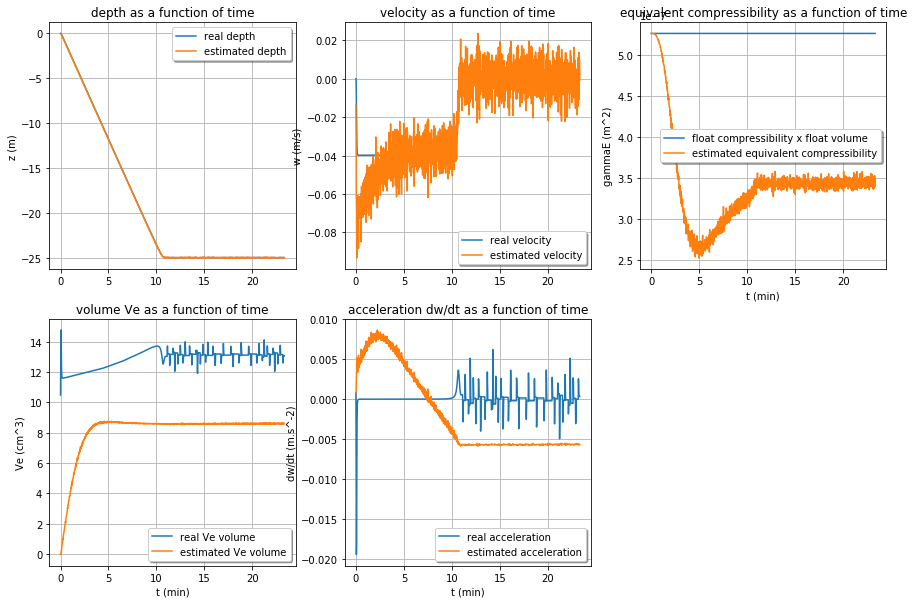

In [13]:
#f.plot_logs(z_target=z_target)
fl.plot_kalman(f.log, f)

---

## Oscillations around a fixed level

In [14]:
z_target = lambda t: -25+10.*np.sin(2.*np.pi/1200.*t)

In [15]:
f.time_step(w,T=1800., dt_step=.1, dt_log=1.,
            piston=True, z_target=z_target, ctrl=control, kalman=kalman)

 ctrl: dt_ctrl = 0.1
 ctrl: dz_nochattering = 0.01
 ctrl: tau = 1.0
 ctrl: nu = 0.025464790894703257
 ctrl: delta = 0.15
 ctrl: gamma = 9.3e-05
 ctrl: L = 0.5
 ctrl: c1 = 1.0
 ctrl: m = 5.796134381066166
 ctrl: gammaV = 5.259026102109313e-07
 ctrl: rho = 1599.5071780735482
 ctrl: a = 1.0
 ctrl: mode = feedback
Start time stepping for 30 min ...
... time stepping done


Extrapolated energy conssumption: 8.3e-04 Wh/day = 0.0 Wh/30day


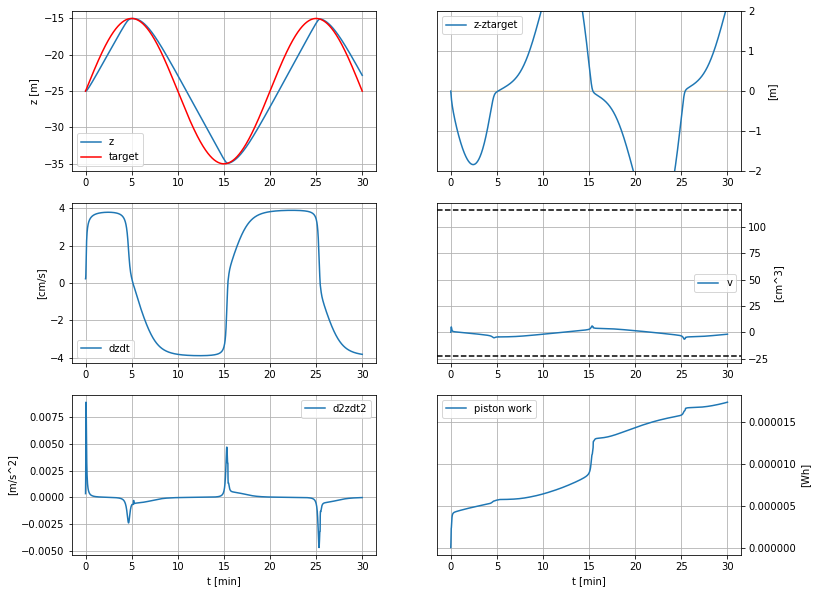

In [16]:
f.plot_logs(z_target=z_target)

---

## Maintains depth level around moving isopycnals

In [17]:
eta = lambda t: 10.*np.sin(2.*np.pi/(60.*20.)*t)
z_target = lambda t: -25.+t*0.

In [18]:
f.time_step(w,T=1800., dt_step=.1, dt_log=1., piston=True, z_target=z_target, ctrl=control, kalman=kalman, eta=eta)

 ctrl: dt_ctrl = 0.1
 ctrl: dz_nochattering = 0.01
 ctrl: tau = 1.0
 ctrl: nu = 0.025464790894703257
 ctrl: delta = 0.15
 ctrl: gamma = 9.3e-05
 ctrl: L = 0.5
 ctrl: c1 = 1.0
 ctrl: m = 5.796134381066166
 ctrl: gammaV = 5.259026102109313e-07
 ctrl: rho = 1599.5071780735482
 ctrl: a = 1.0
 ctrl: mode = feedback
Start time stepping for 30 min ...
... time stepping done


Extrapolated energy conssumption: 1.5e-02 Wh/day = 0.4 Wh/30day


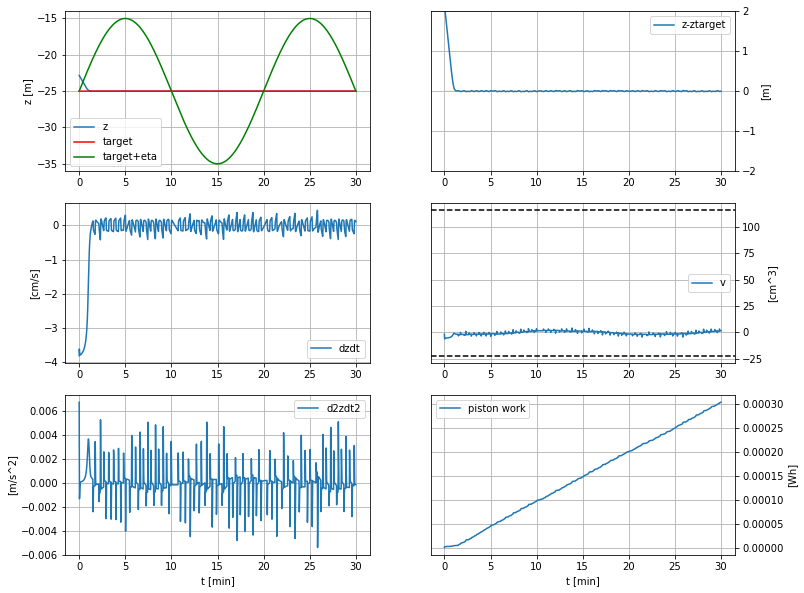

In [19]:
f.plot_logs(z_target=z_target, eta=eta)